# Weather data and solar radiation on a tilted surface

*Note*: These notebooks follow the writing conventions for unit symbols and names recommanded by the *International Bureau of Weights and Measures* ([BIPM 2019](https://www.bipm.org/documents/20126/41483022/SI-Brochure-9-EN.pdf/2d2b50bf-f2b4-9661-f402-5f9d66e4b507?version=1.11&t=1671101192839&download=true)) and *National Institute of Standards and Technology* ([Thomson A. et al. 2008](https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication811e2008.pdf)).

## Introduction

### Objectives

- Download weather data in [EnergyPlus™](https://energyplus.net/documentation) format.
- Read weather data.
- Find solar radiation on a tilted surface.
- Visualize the data.

### Summary
This notebook:

- Imports standard modules such as numpy, pandas, and matplotlib.pyplot, and a dedicated module, dm4bem. It then reads a file in EnergyPlus Weather Format (epw) containing weather data for Lyon, France.

- Selects three columns from the weather data, namely air temperature, direct radiation on a normal surface, and diffuse radiation on an horizontal surface, and replaces the year in the index with 2000.

- Defines a start date and an end date and filters the weather data based on these dates.

- Creates three plots using the filtered weather data:
    - A line plot of outdoor air temperature over time.
    - A line plot of solar radiation (normal direct and horizontal diffuse) over time.
    - A line plot of solar radiation on a tilted surface over time, calculated using the filtered weather data and the slope, azimuth, and latitude of the surface.

- Calculates the solar radiation on a tilted surface by computing the direct radiation, diffuse radiation, and reflected radiation. It then stores the calculated solar radiation as a new column in the filtered weather data.

## Obtain weather data in `EnergyPlus™` format

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dm4bem import read_epw, sol_rad_tilt_surf

### Download data file

Download the weather file with extension `.epw` from: 
- [Climate.OneBuilding.Org](http://climate.onebuilding.org): folder of files at the repository of free climate data for building performance simulation,
- [EnergyPlus™](https://energyplus.net/weather): interactive map with locations,
- [LadyBug Tools](http://www.ladybug.tools/epwmap/): interactive map with locations,
- [PV GIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html): interractive map with interpollated data.

For example, for the airport Lyon-Bron, France (N45.73, E5.08), download the files:
- `FRA_Lyon.074810_IWEC.epw` or 
- `FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018`

and place them in the `./weather_data` folder.

### Read weather data

#### Weather data file name

In [2]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
# filename = './weather_data/FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018.epw'

The weather file `.epw` contains hourly data for one year. For the description of the structure and the meaning of the fileds of the `.epw` file, see `read_epw` function in [dm4bem.py](dm4bem.py) module and the documentation for [pvlib.iotools.read_epw](https://pvlib-python.readthedocs.io/en/v0.9.0/generated/pvlib.iotools.read_epw.html) function of [pvlib python](https://pvlib-python.readthedocs.io/en/v0.9.0/index.html).

In [3]:
[data, meta] = read_epw(filename, coerce_year=None)
data

,year,month,day,hour,minute,data_source_unct,temp_air,temp_dew,relative_humidity,atmospheric_pressure,...,ceiling_height,present_weather_observation,present_weather_codes,precipitable_water,aerosol_optical_depth,snow_depth,days_since_last_snowfall,albedo,liquid_precipitation_depth,liquid_precipitation_quantity
1983-01-01 00:00:00+01:00,1983,1,1,1,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0,0.8,0.3,96,100100,...,15,0,999999599,0,0.204,0,88,0.0,0.0,0.0
1983-01-01 01:00:00+01:00,1983,1,1,2,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,-0.6,-0.9,97,100300,...,30,0,999999599,0,0.204,0,88,0.0,0.0,0.0
1983-01-01 02:00:00+01:00,1983,1,1,3,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,-1.5,-1.7,98,100400,...,30,0,999999599,0,0.204,0,88,0.0,0.0,0.0
1983-01-01 03:00:00+01:00,1983,1,1,4,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0,-1.9,-2.0,99,100500,...,30,0,999999599,0,0.204,0,88,0.0,0.0,0.0
1983-01-01 04:00:00+01:00,1983,1,1,5,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,-2.1,-2.2,100,100500,...,30,0,999999599,0,0.204,0,88,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-12-31 19:00:00+01:00,1986,12,31,20,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,5.9,4.7,92,99400,...,22000,9,999999999,0,0.117,2,88,0.0,0.0,0.0
1986-12-31 20:00:00+01:00,1986,12,31,21,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,5.5,4.5,93,99400,...,22000,9,999999999,0,0.117,2,88,0.0,0.0,0.0
1986-12-31 21:00:00+01:00,1986,12,31,22,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0,4.9,3.9,94,99500,...,22000,9,999999999,0,0.117,2,88,0.0,0.0,0.0
1986-12-31 22:00:00+01:00,1986,12,31,23,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0,3.7,2.9,94,99600,...,22000,9,999999999,0,0.117,2,88,0.0,0.0,0.0


#### Weather data is from different years

Data for each month may be from different years.

In [4]:
# Extract the month and year from the DataFrame index with the format 'MM-YYYY'
month_year = data.index.strftime('%m-%Y')

# Create a set of unique month-year combinations
unique_month_years = sorted(set(month_year))

# Create a DataFrame from the unique month-year combinations
pd.DataFrame(unique_month_years, columns=['Month-Year'])

,Month-Year
0,01-1983
1,02-1985
2,03-1998
3,04-1995
4,05-1986
5,06-1993
6,07-1982
7,08-1993
8,09-1988
9,10-1999


From the dataset, select:

|EPWData field | Description                          | Unit|
|:------------ | ------------------------------------ | --- |
|`temp_air`    |Dry bulb air temperature at timestamp |°C   |
|`dir_n_rad`   |Direct normal radiation received during 1 h prior to timestamp |Wh/m²|
|`dif_h_rad`   |Diffuse horizontal radiation received during 1 h prior to timestamp |Wh/m²|

*Note*: For the description of `.EPW` file, see [pvlib.iotools.epw](https://wholmgren-pvlib-python-new.readthedocs.io/en/stable/_modules/pvlib/iotools/epw.html).

Since in the dataset the values for each month are from different years, we will replace all year with the same year, e.g. `2000`.

In [5]:
# select columns of interest
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]

# replace year of the index with 2000
weather_data.index = weather_data.index.map(
    lambda t: t.replace(year=2000))

#### Start and end time

Select a period for:
- air temperature, °C,
- normal solar radiation, W/m², 
- diffuse solar radiation received during 60 minutes prior to timestamp, W/m². 

In [6]:
# Define start and end dates
start_date = '2000-06-29'
end_date = '2000-07-02'

# Filter the data based on the start and end dates
weather_data = weather_data.loc[start_date:end_date]
del data
weather_data.head()

,temp_air,dir_n_rad,dif_h_rad
2000-06-29 00:00:00+01:00,16.7,0,0
2000-06-29 01:00:00+01:00,17.0,0,0
2000-06-29 02:00:00+01:00,16.0,0,0
2000-06-29 03:00:00+01:00,15.9,0,0
2000-06-29 04:00:00+01:00,16.0,0,0


#### Plot outdoor air temperature

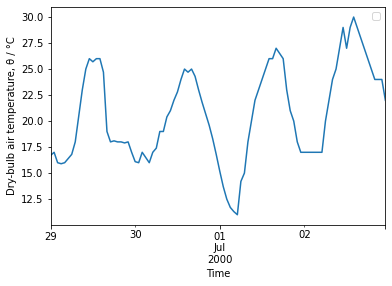

In [7]:
weather_data['temp_air'].plot()
plt.xlabel("Time")
plt.ylabel("Dry-bulb air temperature, θ / °C")
plt.legend([])
plt.show()

> Figure 1. Hourly dry bulb air temperature at timestamp.

#### Plot solar radiation: normal direct and horizontal diffuse

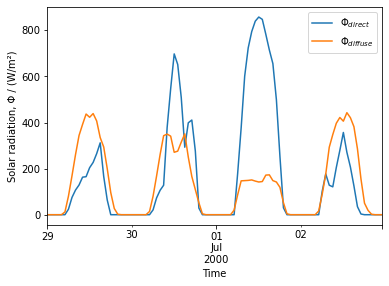

In [8]:
weather_data[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation, Φ / (W/m²)")
plt.legend(['$Φ_{direct}$', '$Φ_{diffuse}$'])
plt.show()

> Figure 2. Hourly-mean direct normal and difuse horizontal solar radiation.

### Solar radiation on a tilted surface

#### Orientation of the tilted wall

For a tilted wall and knowing the albedo of the surface which is in front of it, the diffuse and reflected radiation incident on the wall can be calculated from weather data for each hour.

Let's consider a wall at latitude $\phi$ with the orientation given by its slope angle, $\beta$, and azimuth angle, $\gamma$.

In [9]:
surface_orientation = {'slope': 90,     # 90° is vertical; > 90° downward
                       'azimuth': 0,    # 0° South, positive westward
                       'latitude': 45}  # °, North Pole 90° positive
pd.Series(surface_orientation)

slope       90
azimuth      0
latitude    45
dtype: int64

![t01_orientation_angles](./figures/01_orientation_angles.svg)
>Figure 3. Orientation of a surface: 
>- $\beta$: slope angle: $\beta = 90°$ is vertical; $\beta > 90°$ is downward facing.
>- $\gamma$: azimuth angle: 0° South, positive westward, negative eastward. 
>- $\theta$: incidence angle: angle between the solar beam on the surface and the normal to the surface.
>
>N, S, E, W: North, South, East and West, respectively. $\vec{n}$ is the vector normal to the surface. ∟ represents right angles.

Let's consider that the [albedo](https://en.m.wikipedia.org/wiki/Albedo) of the surface in front of the wall is:

In [10]:
albedo = 0.2

#### Plot the solar radiation

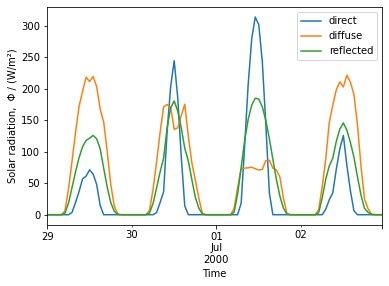

In [11]:
rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation, albedo)

rad_surf.plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation,  Φ / (W/m²)")
plt.show()

>Figure 4. Hourly-mean direct, diffuse and reflected radiation on a tilted surface. 

## Calculation of solar radiation on a tilted surface from weather data

Let’s consider a tilted surface having another surface (e.g., ground) in front of it. Given the weather data, the surface orientation, and the albedo of the ground in front of the surface, find the direct, diffuse and reflected solar radiation for this surface. The algoritm is implemented in the function `sol_rad_tilt_surf` of the `dm4bem.py` module.

### Surface orientation

The orientation of the surface is given by the following angles:
- $\beta$ slope: slope or tilt angle from 0 to 180 degrees
    - β = 0° - horizontal, upward facing;
    - β = 90°- vertical;
    - β < 90°- upward facing;
    - β > 90°- downward facing;
    - 180° - horizontal, downward facing.
- $\gamma$ azimuth: surface azimuth in degrees, $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$; 0-south; westward: positive; eastward: negatif;
- $\phi$ latitude: local latitude in degree $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$; northward: positive, southward: negative.

In [12]:
β = surface_orientation['slope']
γ = surface_orientation['azimuth']
ϕ = surface_orientation['latitude']

# Transform degrees in radians
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180

n = weather_data.index.dayofyear

**Total solar radiation** is the amount of radiation received on a surface during the number of minutes preceding the time indicated:

$$ G_{sr} = G_{dir} + G_{dif} + G_r$$

where:

- $G_{dir}$ **[direct normal](https://en.m.wikipedia.org/wiki/Direct_insolation)** or **beam radiation**: amount of solar radiation received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated, W/m².

- $G_{dif}$ **[diffuse radiation](https://en.m.wikipedia.org/wiki/Diffuse_sky_radiation)**: amount of solar radiation received after scattering by the atmosphere, W/m². Note: it does not include the diffuse infrared radiation emitted by the atmosphere.

- $G_r$ **[total solar radiation coming by reflection](https://en.m.wikipedia.org/wiki/Albedo)** from the surface in front of the wall (usually, ground), W/m².

### Direct radiation

The direct radiation on the surface, $G_{dir}$, depends on the *direct normal (or beam) radiation*, $G_n$, and the *incidence angle*, $\theta$, between the solar beam and the normal to the wall [2] (§11.2.1).

In order to calculate the *incidence angle*, $\theta$, we need:

- $\phi$ *[latitude](https://en.m.wikipedia.org/wiki/Latitude)*, the angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

- $\beta$ *slope*, the angle between the plane of the surface and the horizontal. $0 \le \beta \le 180 ^{\circ}$; $\beta \le 90 ^{\circ}$: the surface is upward facing.

- $\gamma$ *[azimuth](https://en.m.wikipedia.org/wiki/Azimuth)*, the angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$.

- $\delta$ *[declination angle](https://en.m.wikipedia.org/wiki/Declination)*, the angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1](eq. 1.6.1a), [2](§11.2.1.1, eq. (78)):
$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

In [13]:
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
δ = declination_angle * np.pi / 180

- $\omega$ *[solar hour angle](https://en.m.wikipedia.org/wiki/Hour_angle#Solar_hour_angle)*, the angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( hour + \frac{minute}{60} - 12 \right )$$

where *hour* and *minute* is the [solar time](https://en.m.wikipedia.org/wiki/Solar_time#Mean_solar_time).

$-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$. $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of a point on the celestial sphere.

In [14]:
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
ω = hour_angle * np.pi / 180                    # rad

The **[incidence angle](https://en.m.wikipedia.org/wiki/Angle_of_incidence_(optics)**, $\theta$, is the angle between the solar beam on the surface and the normal to the surface [1](eq. 1.6.2), [2] (eq. 78):

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$

If $\beta \le 90^\circ$, then the sun is behind the surface. Therefore, if $\theta > \pi / 2$, then $\theta = \pi / 2$.

In [15]:
theta = np.sin(δ) * np.sin(ϕ) * np.cos(β) \
    - np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ) \
    + np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω) \
    + np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω) \
    + np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)

theta = np.array(np.arccos(theta))
theta = np.minimum(theta, np.pi / 2)

The **direct radiation**, $G_{dir}$ on the surface is:

$$G_{dir} = G_{dir,n} \cos \theta$$

where *direct normal radiation* or *beam radiation*, $G_n$, is the amount of solar radiation (in W/m²) received directly from the solar disk on the surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated. It is given by weather data.

In [16]:
dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

### Diffuse Radiation

The diffuse radiation on the wall is a function on its slope, $\beta$, and 
the isotropic diffuse solar radiation, $G_{dif,h}$, [[2](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html)](§1.2.1.2, eq. 79, p. 31):

$$ G_{dif} = G_{dif,h} \frac{1 + \cos \beta}{2}$$

In [17]:
dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(β)) / 2

### Solar radiation reflected by the ground

Considering the radiation reflected by the ground as isotropic, the reflected radiation that gets onto the wall is a function of its slope, albedo and total horizontal radiation [[2](§11.2.1.3)].

The normal horizontal radiation is [2] (eq. 80):

$$ G_{dir,h} = G_{dn} \sin \gamma$$

In [18]:
gamma = np.cos(δ) * np.cos(ϕ) * np.cos(ω) \
    + np.sin(δ) * np.sin(ϕ)

gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

The total radiation received by reflection is:

$$G_r = (G_{dir,h} + G_{dif,h}) \, \rho \, \frac{1 - \cos \beta}{2}$$

where $\rho$ is the [albedo](https://en.m.wikipedia.org/wiki/Albedo) (or the reflection coefficient) of the surface.

In [19]:
ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo \
        * (1 - np.cos(β) / 2)

### Definitions

#### Radiation and time
$G_{dir,n}$ **Direct normal** or **beam radiation**. Amount of solar radiation in Wh/m² received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated.

$G_{dif,h}$ **Diffuse horizontal radiation**. Amount of solar radiation in Wh/m² received after scattering by the atmosphere. This definition distinguishes the diffuse solar radiation from infrared radiation emitted by the atmosphere.

**Total Solar Radiation**. Total amount of direct and diffuse solar radiation in Wh/m² received on a  surface during the number of minutes preceding the time indicated.

**Global radiation.** Total solar radiation given on a horizontal surface.

**Solar Time.** Time based on the apparent position of the sun in the sky with noon the time when the sun crosses the observer meridian. 

#### Definitions for angles (in degrees)

$\phi$ **Latitude.** Angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

$\beta$ **Slope.** Angle between the plane of the surface and the horizontal. $0 \le \beta \le 180 ^{\circ}$. $\beta < 90^{\circ}$ means that the surface is upward facing.

$\gamma$ **Azimuth.** Angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180^{\circ}$.

$\delta$ **Declination.** Angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1, eq. 1.6.1a):

$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

where $n$ is the day of the year. $-23.45 ^{\circ} \leq \delta \leq 23.45 ^{\circ}$. Declination is used with hour angle to give the direction of a point on the celestial sphere.

$\omega$ **Hour angle.** Angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( h + \frac{min}{60} - 12 \right )$$

where *h* and *min* is the solar time in hours and in minutes, respectively. The hour angle is
$$-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$$

with $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of a point on the celestial sphere.

$\theta$ **Incidence.** Angle between the solar beam on the surface and the normal to the surface [1, eq. 1.6.2]:

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$



## References

1. [Duffie, J.A., Beckman,  W. A., Blair,  N. (2020)](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf) Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

2. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

3. [US Department of Energy (2022)]((https://energyplus.net/assets/nrel_custom/pdfs/pdfs_v22.1.0/EngineeringReference.pdf)) EnergyPlus™ Engineering Reference, version 22.1.0, © 1996-2022

4. [BIPM (2019)](https://www.bipm.org/documents/20126/41483022/SI-Brochure-9-EN.pdf/2d2b50bf-f2b4-9661-f402-5f9d66e4b507?version=1.11&t=1671101192839&download=true) The International System of Units (SI), 9th edition, licence CC-BY-3.0

5. [Gőbel, E., Mills, I., Wallard,  A. (2006)](https://www.bipm.org/documents/20126/41483022/SI-Brochure-9-concise-EN.pdf/2fda4656-e236-0fcb-3867-36ca74eea4e3). A concise summary of the International System of Units, the SI

6. [Thomson, A., Taylor, B. N. (2008)](https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication811e2008.pdf). Guide for the use of the international System of units (NIST Special Publication 811․ 2008 Edition). National Institute of Standards and Technology, US Government Printing Office.

# [Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall](02SimpleWall.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubicBuilding.ipynb)

# [Thermal circuits assembling](04AssemblingCircuits.ipynb)

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# [Control input: heating & cooling and free-running](06Control_Input.ipynb)

# [Radiation coupled with convection](07Coupled_rad_convection.ipynb)

# [Sensible thermal load in steady-state](08Thermal_load.ipynb)

# [Air flow by ventilation](09Air_flow_ventilation.ipynb)